In [1]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade --force-reinstall git+https://github.com/FelipeSchreiber/BregmanClustering.git --no-deps
!pip install torch_geometric
### Uncomment line below if in Google Colab environment
!chmod 777 /usr/local/lib/python3.9/dist-packages/BregmanTests/install_algos.sh
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/FelipeSchreiber/BregmanClustering.git to /tmp/pip-req-build-o9gkccj3
  Running command git clone --filter=blob:none --quiet https://github.com/FelipeSchreiber/BregmanClustering.git /tmp/pip-req-build-o9gkccj3
  Resolved https://github.com/FelipeSchreiber/BregmanClustering.git to commit 7c01c3fcb41b242679f6af9663f6f628e3bac53c
  Preparing metadata (setup.py) ... done
  Created wheel for bregClust: filename=bregClust-1.0-py3-none-any.whl size=34708 sha256=8f8f2f960151469c1ef1dfe6ff620bcc23cd6d61d590e2cf191085fbdae408db
  Stored in directory: /tmp/pip-ephem-wheel-cache-goisf09f/wheels/3f/90/fb/833529540c1d5f19c385fde761cc07c664c4b9a5edf7c6735b
Successfully built bregClust
  Attempting uninstall: bregClust
    Found existing installation: bregClust 1.0
    Uninstalling bregClust-1.0:
      Successfully uninstalled bregClust-1.0
Looking in indexes: https://pypi.org

In [3]:
#%matplotlib inline
from BregmanTests.benchmark import *
from BregmanTests.utils import *
import BregmanTests
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score
#from signet.cluster import Cluster
import scipy.sparse as ss
import pandas as pd
import os
import warnings
from BregmanClustering import models
from BregmanClustering.models import SoftBregmanNodeAttributeGraphClustering as VEMbreg
from BregmanClusteringTorch.torch_models import SoftBregmanClusteringTorch as torchBreg
from BregmanClusteringTorch.torch_models import  SoftBregmanClusteringTorchSparse as sparseBreg
from BregmanClusteringTorch.torch_models import GNNBregmanClustering as gnnBreg
import subprocess
warnings.filterwarnings("ignore")

In [4]:
from BregmanTests import cfg

In [5]:
cfg.base_path

'/usr/local/lib/python3.10/dist-packages/BregmanTests'

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 17 17:08:00 2023

@author: maximilien, Felipe Schreiber
"""
from tqdm import tqdm

In [7]:
c = 3 ## number of communities
n = 100 ##size per community (or you can pass a list with different sizes)
r = 10 ##specify how far the attributes distributions are from the origin
d = 2 ##number of attributes
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])

In [8]:
X,Y,true_labels,G = BregmanBenchmark(P,[n]*c,1,10,dims=d,weight_variance=0.01,att_variance=0.1,\
                       weight_distribution="logistic",attributes_distribution="logistic",radius=r,return_G=True).generate_benchmark_joint()
A = (X != 0).astype(int)

In [9]:
X

array([[ 0.        ,  0.9026869 ,  1.0296422 , ...,  0.        ,
         4.51817738,  0.        ],
       [ 0.9026869 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0296422 ,  0.        ,  0.        , ...,  4.63633143,
         0.        ,  4.66997913],
       ...,
       [ 0.        ,  0.        ,  4.63633143, ...,  0.        ,
         0.        , 10.15123454],
       [ 4.51817738,  0.        ,  0.        , ...,  0.        ,
         0.        ,  9.915039  ],
       [ 0.        ,  0.        ,  4.66997913, ..., 10.15123454,
         9.915039  ,  0.        ]])

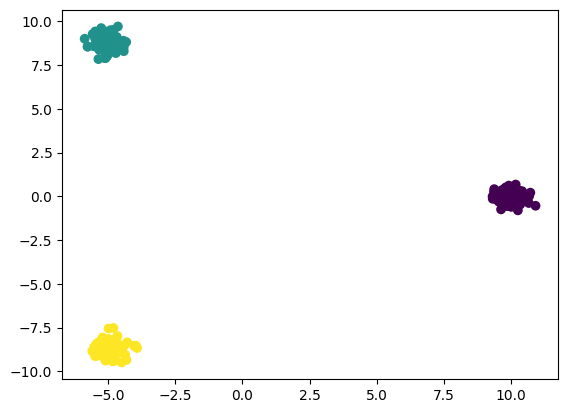

In [10]:
plt.scatter(Y[:,0],Y[:,1],c=true_labels)

In [11]:
pred_labels = spectral(X.copy(),c)
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

1.0 1.0


In [12]:
pred_labels = GaussianMixture(n_components=c).fit_predict(Y.copy())
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

1.0 1.0


In [13]:
from BregmanClustering.models import BregmanNodeEdgeAttributeGraphClustering as edgeBreg
model = edgeBreg(n_clusters = c,initializer="chernoff")
model.fit(A, A.reshape(300,300,1), Y)
z_pred_both = model.predict(A,Y)
print(adjusted_rand_score(true_labels, z_pred_both),normalized_mutual_info_score(true_labels, z_pred_both))

1.0 1.0


In [14]:
import networkx as nx
nx.adjacency_matrix(G).todense() 

array([[ 0.        ,  0.9026869 ,  1.0296422 , ...,  0.        ,
         4.51817738,  0.        ],
       [ 0.9026869 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0296422 ,  0.        ,  0.        , ...,  4.63633143,
         0.        ,  4.66997913],
       ...,
       [ 0.        ,  0.        ,  4.63633143, ...,  0.        ,
         0.        , 10.15123454],
       [ 4.51817738,  0.        ,  0.        , ...,  0.        ,
         0.        ,  9.915039  ],
       [ 0.        ,  0.        ,  4.66997913, ..., 10.15123454,
         9.915039  ,  0.        ]])

In [15]:
from BregmanClustering.models import BregmanNodeEdgeAttributeGraphClustering as edgeBreg
# from BregmanTests.install_algorithms import main as install_env
# import BregmanTests
# ## Optional: set repository for CRAN
# BregmanTests.cfg.CRAN_repo = "https://cran.fiocruz.br/"
# install_env()
from CSBM.Python.functions import *

In [16]:
from copy import deepcopy

In [ ]:
n_average = 40
n = 600
n_clusters = 2
d = 1
binary=True
sizes = [ n // n_clusters ]*np.ones( n_clusters, dtype = int )
attributes_distribution = "gaussian"
edge_distribution = "bernoulli"
weight_distribution = "exponential"

b = 5
pout = b * np.log( n ) / n

a_range = [ 5,7,9,11,13,15 ]
r_range = [ 0,1,2,3,4,5 ]
# a_range = [ 5,7]
# r_range = [ 0,1]

stats = {"varying":[],"a":[],"r":[],"ARI":[],"ARI_std":[],"algorithm":[]}

for varying in ["attributes","graph"]:
# varying = 'attributes'
# #varying = 'graph'

    aris_attributes_mean = [ ]
    aris_graph_mean = [ ]
    aris_both_mean = [ ]
    aris_attSBM_mean = [ ]
    aris_IR_sLS_mean = [ ]
    # aris_IR_LS_mean = [ ]


    aris_attributes_std = [ ]
    aris_graph_std = [ ]
    aris_both_std = [ ]
    aris_attSBM_std = [ ]
    aris_IR_sLS_std = [ ]
    aris_IR_LS_std = [ ]
    # aris_both2_std = [ ]
    # aris_oracle_std = [ ]

    if varying == 'graph':
        loop = tqdm( range( len( a_range ) ) )
    else:
        loop = tqdm( range( len( r_range ) ) )

    for dummy in loop:
        if varying == 'graph':
            a = a_range[ dummy ]
            r = 1
        elif varying == 'attributes':
            a = 8
            r = r_range[ dummy ]

        pin = a * np.log( n ) / n
        p = (pin- pout) * np.eye( n_clusters ) + pout * np.ones( (n_clusters, n_clusters) )

        aris_attributes = [ ]
        aris_graph = [ ]
        aris_both = [ ]
        aris_attSBM = [ ]
        aris_IR_sLS  = [ ]
        # aris_IR_LS = [ ]
        # aris_oracle = [ ]
        
        path_ = BregmanTests.cfg.path_to_data+f"a/{a}/r/{r}/"
        if not os.path.exists(path_):
            os.makedirs(path_)

        total = 0
        for trial in range( n_average ):
            ( X, Y, z_true, G) = BregmanBenchmark(p,sizes,att_variance=1,\
                    attributes_distribution=attributes_distribution,\
                    weight_variance=1,\
                    weight_distribution=weight_distribution,\
                    radius=r,return_G=False).generate_benchmark_joint()
            
            A = (X != 0).astype(int)
            model = edgeBreg(n_clusters=n_clusters,\
                              attributeDistribution=attributes_distribution,\
                              edgeDistribution=edge_distribution,\
                              weightDistribution=weight_distribution,
                              initializer="chernoff"
                              )
            if binary:
              X = A
            ## For comparison purposes, the initialization is the same for IR-sLS, IR-LS and ours    
            model.initialize(A,X.reshape(n,n,-1),Y)
            model.assignInitialLabels(A, Y)
            z_init = deepcopy(model.predicted_memberships)
            chernoff_init_graph = model.graph_init
            chernoff_graph_labels = model.memberships_from_graph
            chernoff_att_labels = model.memberships_from_attributes

            with open(f'{path_}att_{trial}.npy', 'wb') as g:
                np.save(g, Y)
            with open(f'{path_}net_{trial}.npy', 'wb') as g:
                np.save(g, A)
            with open(f'{path_}z_init_{trial}.npy', 'wb') as g:
                np.save(g, convertZ(z_init)+1)

            z_pred_both = model.fit(A,X.reshape(n,n,-1),Y).predict( X, Y )
            z_pred_graph = models.frommembershipMatriceToVector( chernoff_graph_labels )
            z_pred_attributes = models.frommembershipMatriceToVector( chernoff_att_labels )
            
            # this code is for initialization comparison
            ### > Start
            # if chernoff_init_graph == model.AIC_initializer(X,Y).graph_init:
            #     total += 1
            
            # ## Warm start
            # if model.graph_init:
            #     model.fit( X, Y, chernoff_graph_labels)
            # else:
            #     model.fit(X, Y, chernoff_att_labels)
            ### > end
            
            IR_sLS_pred = iter_csbm(X,Y,z_init,n_clusters)
            # IR_LS_pred = iter_csbm2(X,Y,z_init,n_clusters)
                
            subprocess.call(["/usr/bin/Rscript","--vanilla",f"{BregmanTests.cfg.base_path}/run_AttSBM.r",\
                            f'{path_}att_{trial}.npy',\
                            f'{path_}net_{trial}.npy',\
                            f'{path_}z_init_{trial}.npy'])
            attSBMPred = np.load("predict.npy")

            aris_attributes.append( adjusted_rand_score( z_true, z_pred_attributes ) )
            aris_graph.append( adjusted_rand_score( z_true, z_pred_graph ) )
            aris_both.append( adjusted_rand_score( z_true, z_pred_both ) )
            aris_attSBM.append( adjusted_rand_score( z_true, attSBMPred ) )
            aris_IR_sLS.append( adjusted_rand_score( z_true, IR_sLS_pred ) )
            #aris_IR_LS.append( adjusted_rand_score( z_true, IR_LS_pred ) )
            
            # if chernoff_init_graph:
            #   z_pred_att_init = model.fit(A,A.reshape(n,n,1),Y,chernoff_att_labels).predict( X, Y )
            #   ari_att_init = adjusted_rand_score( z_true, z_pred_att_init)
            #   aris_oracle.append( max(aris_both[-1], ari_att_init))
            # elif not chernoff_init_graph:
            #   z_pred_graph_init = model.fit(A,A.reshape(n,n,1),Y,chernoff_graph_labels).predict( X, Y )
            #   ari_graph_init = adjusted_rand_score( z_true, z_pred_graph_init)
            #   aris_oracle.append( max(aris_both[-1], ari_graph_init))
                
        aris_attributes_mean.append( np.mean( aris_attributes ) )
        aris_graph_mean.append( np.mean( aris_graph ) )
        aris_both_mean.append( np.mean( aris_both ) )
        aris_attSBM_mean.append( np.mean( aris_attSBM ) )
        aris_IR_sLS_mean.append( np.mean( aris_IR_sLS ) )
        #aris_IR_LS_mean.append( np.mean( aris_IR_LS ) )
        #aris_oracle_mean.append( np.mean( aris_oracle) )
        
        aris_attributes_std.append( np.std( aris_attributes ) )
        aris_graph_std.append( np.std( aris_graph ) )
        aris_both_std.append( np.std( aris_both ) )
        aris_attSBM_std.append( np.std( aris_attSBM ) )
        aris_IR_sLS_std.append( np.std( aris_IR_sLS ) )
        # aris_IR_LS_std.append( np.std( aris_IR_LS ) )
        # aris_oracle_std.append( np.std( aris_oracle) )
        
        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["ARI"].append(aris_both_mean[-1])
        stats["ARI_std"].append(aris_both_mean[-1])
        stats["algorithm"].append("ours")

        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["ARI"].append(aris_IR_sLS_mean[-1])
        stats["ARI_std"].append(aris_IR_sLS_std[-1])
        stats["algorithm"].append("IR_sLS")

        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["ARI"].append(aris_attSBM_mean[-1])
        stats["ARI_std"].append(aris_attSBM_std[-1])
        stats["algorithm"].append("attSBM")

        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["ARI"].append(aris_graph_mean[-1])
        stats["ARI_std"].append(aris_graph_std[-1])
        stats["algorithm"].append("graph")

        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["ARI"].append(aris_attributes_mean[-1])
        stats["ARI_std"].append(aris_attributes_std[-1])
        stats["algorithm"].append("attributes")
        
    curves = [ aris_attributes_mean, aris_graph_mean,\
              aris_both_mean , aris_attSBM_mean, aris_IR_sLS_mean]

    curves_std = [ aris_attributes_std, aris_graph_std,\
                  aris_both_std , aris_attSBM_std, aris_IR_sLS_std]

    labels = [ 'attributes', 'graph', 'ours' , 'attSBM', 'IR_sLS']
    saveFig = True
    if varying == 'graph':    
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_b_' + str(b) + '_r_' + str(r) +  '_nAverage' + str(n_average) + '.jpeg'
        plotting( a_range, curves, labels, curves_std = curves_std, xticks = a_range, xlabel = 'a', saveFig = saveFig, fileName = fileName )
        plt.close()
    elif varying == 'attributes':
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_a_' + str(a) + '_b_' + str(b) +  '_nAverage_' + str(n_average) + '.jpeg'
        plotting( r_range, curves, labels, curves_std = curves_std, xticks = r_range, xlabel = 'r', saveFig = saveFig, fileName = fileName )
        plt.close()

 33%|███▎      | 2/6 [39:55<1:19:42, 1195.72s/it]

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(stats)

In [ ]:
df

In [ ]:
with open('test_0.pickle', 'wb') as handle:
    pickle.dump(stats, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp "/content/test_0.pickle" "/content/drive/MyDrive"

In [ ]:
test_0=None
with open("/content/drive/MyDrive/test_0.pickle", 'rb') as handle:
    test_0 = pickle.load(handle)
test_0.keys()

In [ ]:
pd.DataFrame.from_dict(test_0)